In [1]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow import gradients
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.random.set_random_seed(0)
np.random.seed(0)

In [4]:
#Load the input data, their corresponding class labels, and the ROI mask
data = np.load("data/data.npy")
labels= np.load("data/labels.npy")
rois = np.load("data/maskROI.npy")

In [5]:
#Randomly split the data
index = np.random.RandomState(seed=1).permutation(9000)
all_data = data[index]
all_labels = labels[index]
train_data = all_data[0:8800]
train_labels= all_labels[0:8800][:,0]-1
val_data = all_data[8800:8900]
val_labels= all_labels[8800:8900][:,0]-1
test_data = all_data[8900:9000]
test_labels= all_labels[8900:9000][:,0]-1

In [6]:
#Get indices for inputs from each class
where_train_0 = np.where(train_labels==0)
where_train_1 = np.where(train_labels==1)
where_train_2 = np.where(train_labels==2)
where_val_0 = np.where(val_labels==0)
where_val_1 = np.where(val_labels==1)
where_val_2 = np.where(val_labels==2)
where_test_0 = np.where(test_labels==0)
where_test_1 = np.where(test_labels==1)
where_test_2 = np.where(test_labels==2)

In [7]:
#Load the template images for the three classes
temp_0 = np.load("data/classPrototype1.npy")
temp_1 = np.load("data/classPrototype2.npy")
temp_2 = np.load("data/classPrototype3.npy")
temp_avg = (temp_0+temp_1+temp_2)/3.0
temp_array = np.array([temp_0,temp_1,temp_2])

In [8]:
train_templates = temp_array = np.array([train_data[where_train_0[0]].mean(axis=0),train_data[where_train_1[0]].mean(axis=0),train_data[where_train_2[0]].mean(axis=0)])

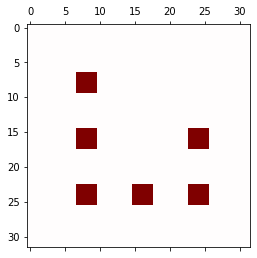

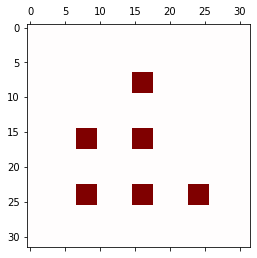

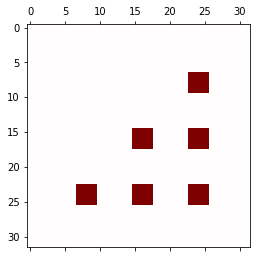

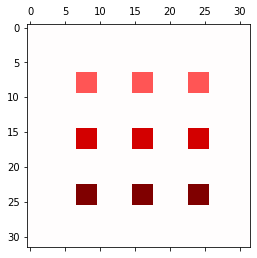

In [9]:
#Plot the three template images and the averge template image
clim = np.abs(temp_0).max()
plt.matshow(temp_0,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_1).max()
plt.matshow(temp_1,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_2).max()
plt.matshow(temp_2,cmap='seismic',vmin=-1.0*clim,vmax=clim)
clim = np.abs(temp_avg).max()
plt.matshow(temp_avg,cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [10]:
#Get difference maps for the avg template with respect to the other templates
diff_0 = temp_0 - temp_avg
diff_1 = temp_1 - temp_avg
diff_2 = temp_2 - temp_avg

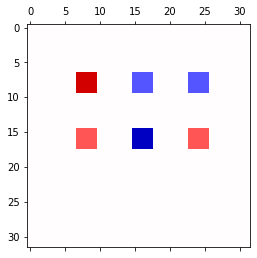

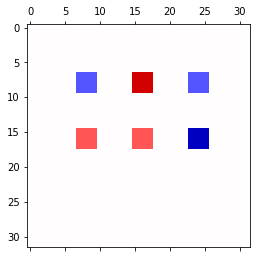

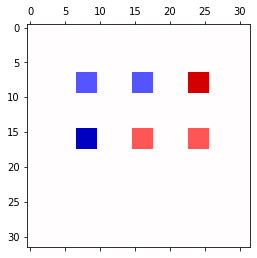

In [11]:
#Plot the difference maps for the avg template with respect to the other templates
plt.matshow(diff_0,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_1,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(diff_2,cmap='seismic',vmin=-1.0,vmax=1)

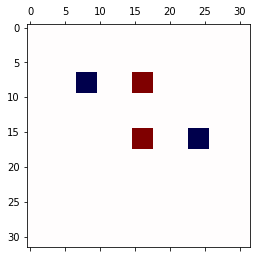

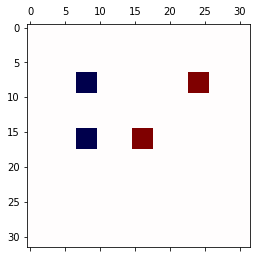

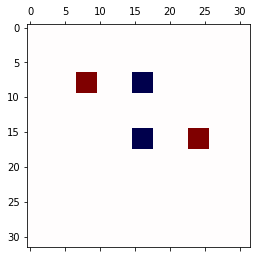

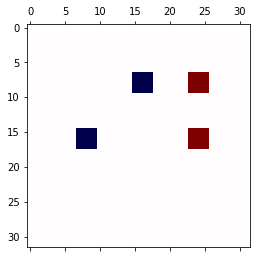

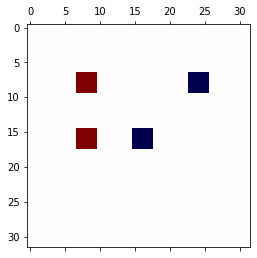

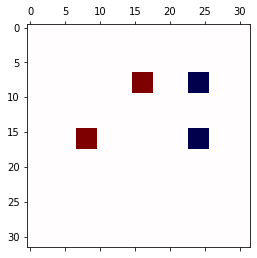

In [12]:
#Plot the difference maps for the avg template with respect to the other templates
plt.matshow(temp_1-temp_0,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(temp_2-temp_0,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(temp_0-temp_1,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(temp_2-temp_1,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(temp_0-temp_2,cmap='seismic',vmin=-1.0,vmax=1)
plt.matshow(temp_1-temp_2,cmap='seismic',vmin=-1.0,vmax=1)

In [13]:
test_0_shape = test_data[where_test_0[0],:,:].shape
test_0 = np.reshape(test_data[where_test_0[0],:,:],[test_0_shape[0],-1])
test_1_shape = test_data[where_test_1[0],:,:].shape
test_1 = np.reshape(test_data[where_test_1[0],:,:],[test_1_shape[0],-1])
test_2_shape = test_data[where_test_2[0],:,:].shape
test_2 = np.reshape(test_data[where_test_2[0],:,:],[test_2_shape[0],-1])

In [14]:
#Declare Tensorflow input and output tensors

x = tf.placeholder(tf.float32, (None, 32,32), name = 'x')
        
y_true = tf.placeholder(tf.int64, (None), name='y')

x_flat = tf.contrib.layers.flatten(x)

mask_true = tf.one_hot(y_true,3)

In [15]:
#Declare correlation model
with tf.variable_scope('c'):
    
    #x_flat_z = (x_flat - tf.keras.backend.mean(x_flat,axis=-1,keepdims=True))/tf.keras.backend.std(x_flat,axis=-1,keepdims=True)
    x_flat_z = x_flat/tf.norm(x_flat,axis=1,keepdims=True)
    w_flat = np.reshape(train_templates,[3,-1])
    #w_flat_z = (w_flat-w_flat.mean(axis=1,keepdims=True))/w_flat.std(axis=1,keepdims=True)
    w_flat_z = w_flat/np.linalg.norm(w_flat,axis=1,keepdims=True)
    w_flat_z_T = tf.convert_to_tensor(w_flat_z.T,dtype=tf.float32)
    
    y_logits_c = tf.matmul(x_flat_z,w_flat_z_T)

    loss_c = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_c)

    probs_c = tf.nn.softmax(y_logits_c/1.0)

    acc_c = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_c, 1)),tf.float32))

    masked_loss_c = tf.reduce_sum( probs_c * mask_true,axis = -1)

    masked_logits_c = tf.reduce_sum(y_logits_c  * mask_true,axis = -1)

    g_c = tf.gradients(masked_loss_c,x)

In [16]:
#Declare linear model
with tf.variable_scope('l'):
    
    y_logits_l = tf.contrib.layers.fully_connected(x_flat,3,weights_regularizer=tf.keras.regularizers.l2(l=1e-5),activation_fn=None)

    y_logits_l = y_logits_l

    loss_l = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_l)

    probs_l = tf.nn.softmax(y_logits_l)

    acc_l = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_l, 1)),tf.float32))

    train_l = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_l)

    masked_loss_l = tf.reduce_sum( probs_l * mask_true,axis = -1)

    masked_logits_l = tf.reduce_sum(y_logits_l  * mask_true,axis = -1)

    w = tf.gradients(masked_logits_l,x)

    g_l = tf.gradients(masked_loss_l,x)

In [17]:
#Declare structured linear model
with tf.variable_scope('sl'):
    h_sl = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sl = tf.contrib.layers.fully_connected(h_sl,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sl = y_logits_sl

    loss_sl = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sl)

    probs_sl = tf.nn.softmax(y_logits_sl)

    loss_sl = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sl)

    acc_sl = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_sl, 1)),tf.float32))

    train_sl = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_sl)

    masked_loss_sl = tf.reduce_sum( probs_sl * mask_true,axis = -1)

    masked_logits_sl = tf.reduce_sum( y_logits_sl * mask_true,axis = -1)

    g_sl = tf.gradients(masked_loss_sl,x)

In [18]:
#Declare neural network model
with tf.variable_scope('nn'):
    h_nn = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = tf.contrib.layers.fully_connected(h_nn,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_nn = y_logits_nn

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    probs_nn = tf.nn.softmax(y_logits_nn)

    loss_nn = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_nn)

    acc_nn = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_nn, 1)),tf.float32))

    train_nn = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_nn)

    masked_loss_nn = tf.reduce_sum( probs_nn * mask_true,axis = -1)

    masked_logits_nn = tf.reduce_sum( y_logits_nn * mask_true,axis = -1)

    g_nn = tf.gradients(masked_loss_nn,x)

In [19]:
#Declare neural network with random spherical noise model
with tf.variable_scope('sph'):
    h_sph = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = tf.contrib.layers.fully_connected(h_sph,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sph = y_logits_sph

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    probs_sph = tf.nn.softmax(y_logits_sph)

    loss_sph = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sph)

    acc_sph = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_sph, 1)),tf.float32))

    train_sph = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_sph)

    masked_loss_sph = tf.reduce_sum( probs_sph * mask_true,axis = -1)

    masked_logits_sph = tf.reduce_sum( y_logits_sph * mask_true,axis = -1)

    g_sph = tf.gradients(masked_loss_sph,x)

In [20]:
#Declare structued linear model with advesarial training model 
with tf.variable_scope('sla'):
    
    h_sla = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_sla = tf.contrib.layers.fully_connected(h_sla,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    loss_sla = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_sla)

    probs_sla = tf.nn.softmax(y_logits_sla)

    acc_sla = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_sla, 1)),tf.float32))

    train_sla = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_sla)

    masked_loss_sla = tf.reduce_sum( probs_sla * mask_true,axis = -1)

    masked_logits_sla = tf.reduce_sum(y_logits_sla * mask_true,axis = -1)

    g_sla = tf.gradients(masked_loss_sla,x)

In [21]:
#Declare neural network with advesarial training model 
with tf.variable_scope('adv'):
    
    h_adv = tf.contrib.layers.fully_connected(x_flat,20,activation_fn=tf.nn.relu,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    y_logits_adv = tf.contrib.layers.fully_connected(h_adv,3,activation_fn=None,weights_regularizer=tf.keras.regularizers.l2(l=1e-5))

    loss_adv = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_logits_adv)

    probs_adv = tf.nn.softmax(y_logits_adv)

    acc_adv = tf.reduce_mean(tf.dtypes.cast(tf.equal(y_true,tf.argmax(y_logits_adv, 1)),tf.float32))

    train_adv = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_adv)

    masked_loss_adv = tf.reduce_sum( probs_adv * mask_true,axis = -1)

    masked_logits_adv = tf.reduce_sum(y_logits_adv * mask_true,axis = -1)

    g_adv = tf.gradients(masked_loss_adv,x)

In [22]:
#Declare model savers
vars_l = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='l')
saver_l = tf.train.Saver(vars_l)
vars_sl = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='sl')
saver_sl = tf.train.Saver(vars_sl)
vars_nn = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='nn')
saver_nn = tf.train.Saver(vars_nn)
vars_sph = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='sph')
saver_sph = tf.train.Saver(vars_sph)
vars_sla = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='sla')
saver_sla = tf.train.Saver(vars_sla)
vars_adv = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='adv')
saver_adv = tf.train.Saver(vars_adv)

In [23]:
#Get validation results for the correlation model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    l_c, a_c = sess.run([loss_c, acc_c], feed_dict={x: val_data, y_true: val_labels})
    print('Loss C: ' + str(l_c[0]))
    print('Acc C: ' + str(a_c))

Loss C: 1.0316368
Acc C: 1.0


In [24]:
#Get test results for the correlation model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    l_c, a_c = sess.run([loss_c, acc_c], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_c[0]))
    print('Acc L: ' + str(a_c))

Loss L: 1.0337375
Acc L: 1.0


In [25]:
#Get test data gradients for the correlation model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_c_0 = sess.run(g_c, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    gradxi_c_0 = grad_c_0 * x_0
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_c_1 = sess.run(g_c, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    gradxi_c_1 = grad_c_1 * x_1
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_c_2 = sess.run(g_c, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    gradxi_c_2 = grad_c_2 * x_2
    
    #Get gradients for class 1 for class 0 inputs
    grad_c_0_1 = sess.run(g_c, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_c_0_1 = grad_c_0_1 * x_0
    
    #Get gradients for class 2 for class 0 inputs
    grad_c_0_2 = sess.run(g_c, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_c_0_2 = grad_c_0_2 * x_0
    
    #Get gradients for class 0 for class 1 inputs 
    grad_c_1_0 = sess.run(g_c, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_c_1_0 = grad_c_1_0 * x_1
    
    #Get gradients for class 2 for class 1 inputs
    grad_c_1_2 = sess.run(g_c, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_c_1_2 = grad_c_1_2 * x_1

    #Get gradients for class 0 for class 2 inputs
    grad_c_2_0 = sess.run(g_c, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    gradxi_c_2_0 = grad_c_2_0 * x_2
    
    #Get gradients for class 1 for class 2 inputs
    grad_c_2_1 = sess.run(g_c, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})
    
    gradxi_c_2_1 = grad_c_2_1 * x_2

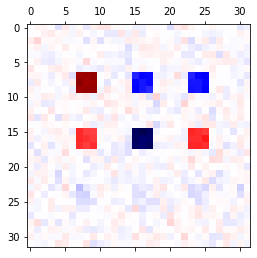

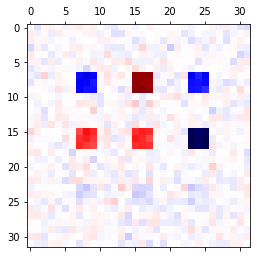

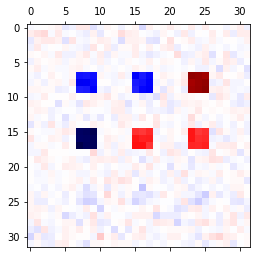

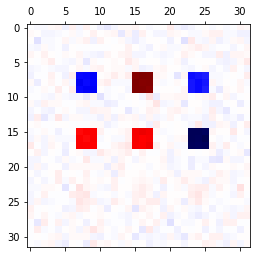

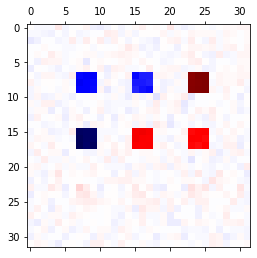

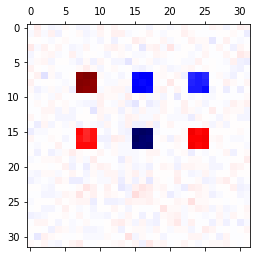

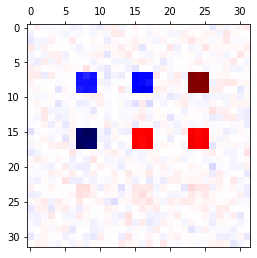

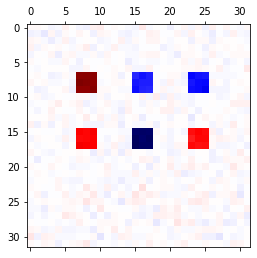

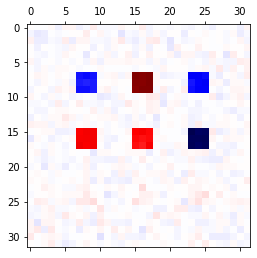

In [26]:
#Plot gradients for the linear model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_c_0[0][1]).max()
plt.matshow(np.reshape(grad_c_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_c_1[0][1]).max()
plt.matshow(np.reshape(grad_c_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_c_2[0][1]).max()
plt.matshow(np.reshape(grad_c_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_c_0_1[0][1]).max()
plt.matshow(np.reshape(grad_c_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_c_0_2[0][1]).max()
plt.matshow(np.reshape(grad_c_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_c_1_0[0][1]).max()
plt.matshow(np.reshape(grad_c_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_c_1_2[0][1]).max()
plt.matshow(np.reshape(grad_c_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_c_2_0[0][1]).max()
plt.matshow(np.reshape(grad_c_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_c_2_1[0][1]).max()
plt.matshow(np.reshape(grad_c_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [27]:
#Train linear model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_l, a_l = sess.run([train_l, loss_l, acc_l], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_l[0]))
        print('Acc L: ' + str(a_l))
    saver_l.save(sess, "saved_models/model_l.ckpt", write_meta_graph=False)

Loss L: 2.1889062
Acc L: 0.34852272
Loss L: 2.122162
Acc L: 0.36420456
Loss L: 2.057189
Acc L: 0.37875
Loss L: 1.9949882
Acc L: 0.3934091
Loss L: 1.936528
Acc L: 0.41306818
Loss L: 1.8826457
Acc L: 0.43102273
Loss L: 1.8337564
Acc L: 0.45329547
Loss L: 1.7895677
Acc L: 0.4725
Loss L: 1.7491736
Acc L: 0.49386364
Loss L: 1.7113743
Acc L: 0.51613635
Loss L: 1.6749289
Acc L: 0.5395455
Loss L: 1.6386704
Acc L: 0.56
Loss L: 1.6015835
Acc L: 0.58431816
Loss L: 1.562876
Acc L: 0.60795456
Loss L: 1.5220118
Acc L: 0.63125
Loss L: 1.4787117
Acc L: 0.6556818
Loss L: 1.432979
Acc L: 0.67875
Loss L: 1.3851128
Acc L: 0.7006818
Loss L: 1.335624
Acc L: 0.72147727
Loss L: 1.2851229
Acc L: 0.7403409
Loss L: 1.2342458
Acc L: 0.7623864
Loss L: 1.1836028
Acc L: 0.78329545
Loss L: 1.1337451
Acc L: 0.8009091
Loss L: 1.0851333
Acc L: 0.81863636
Loss L: 1.0381165
Acc L: 0.83625
Loss L: 0.99291825
Acc L: 0.85079545
Loss L: 0.9496348
Acc L: 0.8681818
Loss L: 0.90825105
Acc L: 0.8815909
Loss L: 0.8686684
Acc L: 0.

In [28]:
#Get validation results for the linear model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))


INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.296736
Acc L: 1.0


In [29]:
#Get test results for the linear model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    l_l, a_l = sess.run([loss_l, acc_l], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_l[0]))
    print('Acc L: ' + str(a_l))

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt
Loss L: 0.20179316
Acc L: 1.0


In [30]:
#Get weights and test data gradients for the linear model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_l.restore(sess, "saved_models/model_l.ckpt")
    #Get weights and gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_l_0, weights_l_0 = sess.run([g_l,w], feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get weights and gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_l_1, weights_l_1 = sess.run([g_l,w], feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get weights and gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_l_2, weights_l_2 = sess.run([g_l,w], feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get weights and gradients for class 1 for class 0 inputs
    grad_l_0_1, weights_l_0_1 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 0 inputs
    grad_l_0_2, weights_l_0_2 = sess.run([g_l,w], feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 1 inputs 
    grad_l_1_0, weights_l_1_0 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 2 for class 1 inputs
    grad_l_1_2, weights_l_1_2 = sess.run([g_l,w], feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get weights and gradients for class 0 for class 2 inputs
    grad_l_2_0, weights_l_2_0 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get weights and gradients for class 1 for class 2 inputs
    grad_l_2_1, weights_l_2_1 = sess.run([g_l,w], feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_l.ckpt


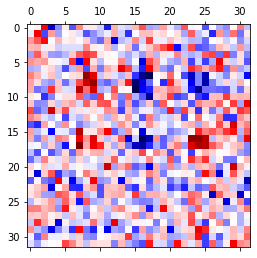

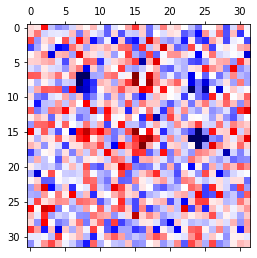

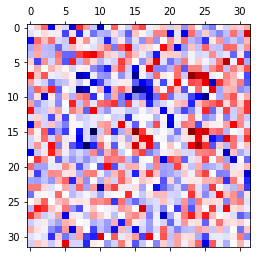

In [31]:
#Plot linear model weights for the three classes
#Plot weights for class 0
clim = np.abs(weights_l_0[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_0[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 1
clim = np.abs(weights_l_1[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_1[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)
#Plot weights for class 2
clim = np.abs(weights_l_2[0].mean(axis=0)).max()
plt.matshow(np.reshape(weights_l_2[0].mean(axis=0),[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

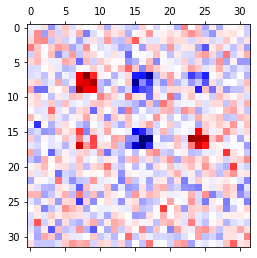

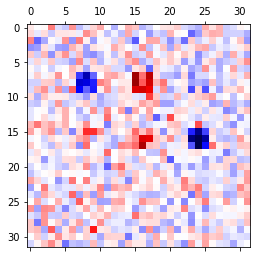

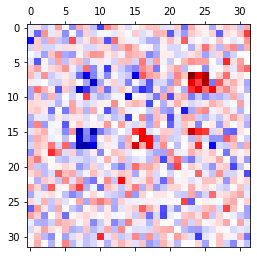

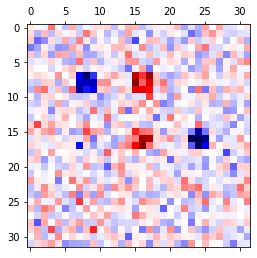

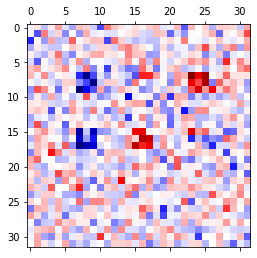

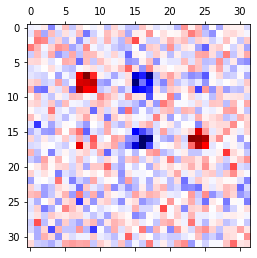

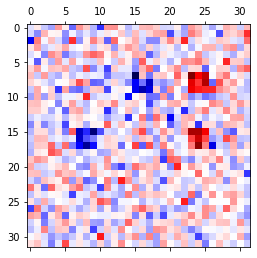

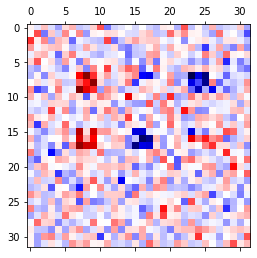

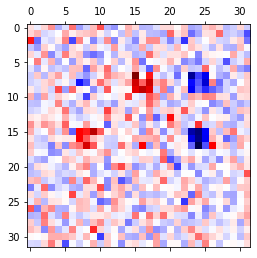

In [32]:
#Plot gradients for the linear model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_l_0[0][1]).max()
plt.matshow(np.reshape(grad_l_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_l_1[0][1]).max()
plt.matshow(np.reshape(grad_l_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_l_2[0][1]).max()
plt.matshow(np.reshape(grad_l_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_l_0_1[0][1]).max()
plt.matshow(np.reshape(grad_l_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_l_0_2[0][1]).max()
plt.matshow(np.reshape(grad_l_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_l_1_0[0][1]).max()
plt.matshow(np.reshape(grad_l_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_l_1_2[0][1]).max()
plt.matshow(np.reshape(grad_l_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_l_2_0[0][1]).max()
plt.matshow(np.reshape(grad_l_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_l_2_1[0][1]).max()
plt.matshow(np.reshape(grad_l_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [33]:
#Train structured linear model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_sl, a_sl = sess.run([train_sl, loss_sl, acc_sl], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_sl[0]))
        print('Acc L: ' + str(a_sl))
    saver_sl.save(sess, "saved_models/model_sl.ckpt", write_meta_graph=False)

Loss L: 0.2339794
Acc L: 0.42988637
Loss L: 0.23483819
Acc L: 0.47556818
Loss L: 0.23515278
Acc L: 0.5305682
Loss L: 0.23638509
Acc L: 0.58181816
Loss L: 0.23851994
Acc L: 0.6396591
Loss L: 0.23992799
Acc L: 0.69113636
Loss L: 0.23935756
Acc L: 0.7394318
Loss L: 0.23670475
Acc L: 0.78909093
Loss L: 0.23245126
Acc L: 0.8356818
Loss L: 0.22722419
Acc L: 0.8759091
Loss L: 0.22153808
Acc L: 0.9102273
Loss L: 0.21568611
Acc L: 0.9359091
Loss L: 0.20975785
Acc L: 0.95511365
Loss L: 0.20369534
Acc L: 0.96875
Loss L: 0.1973531
Acc L: 0.97727275
Loss L: 0.19056246
Acc L: 0.9843182
Loss L: 0.18318807
Acc L: 0.9892045
Loss L: 0.17517576
Acc L: 0.99215907
Loss L: 0.1665639
Acc L: 0.99465907
Loss L: 0.15746853
Acc L: 0.9965909
Loss L: 0.14805119
Acc L: 0.9977273
Loss L: 0.13849106
Acc L: 0.99863636
Loss L: 0.12896317
Acc L: 0.9990909
Loss L: 0.11962183
Acc L: 0.9994318
Loss L: 0.11059197
Acc L: 0.99954545
Loss L: 0.10196503
Acc L: 0.99988633
Loss L: 0.093800634
Acc L: 0.99988633
Loss L: 0.08613157


In [34]:
#Get validation results for the structured model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sl.restore(sess, "saved_models/model_sl.ckpt")
    l_sl, a_sl = sess.run([loss_sl, acc_sl], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_sl[0]))
    print('Acc L: ' + str(a_sl))

INFO:tensorflow:Restoring parameters from saved_models/model_sl.ckpt
Loss L: 0.13869718
Acc L: 1.0


In [35]:
#Get test results for the structured linear model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sl.restore(sess, "saved_models/model_sl.ckpt")
    l_sl, a_sl = sess.run([loss_sl, acc_sl], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_sl[0]))
    print('Acc L: ' + str(a_sl))

INFO:tensorflow:Restoring parameters from saved_models/model_sl.ckpt
Loss L: 0.034153383
Acc L: 1.0


In [36]:
#Get test data gradients for the structured linear model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sl.restore(sess, "saved_models/model_sl.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_sl_0 = sess.run(g_sl, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    gradxi_sl_0 = grad_sl_0 * x_0
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_sl_1 = sess.run(g_sl, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    gradxi_sl_1 = grad_sl_1 * x_1
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_sl_2 = sess.run(g_sl, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    gradxi_sl_2 = grad_sl_2 * x_2
    
    #Get gradients for class 1 for class 0 inputs
    grad_sl_0_1 = sess.run(g_sl, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_sl_0_1 = grad_sl_0_1 * x_0
    
    #Get gradients for class 2 for class 0 inputs
    grad_sl_0_2 = sess.run(g_sl, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_sl_0_2 = grad_sl_0_2 * x_0
    
    #Get gradients for class 0 for class 1 inputs 
    grad_sl_1_0 = sess.run(g_sl, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_sl_1_0 = grad_sl_1_0 * x_1
    
    #Get gradients for class 2 for class 1 inputs
    grad_sl_1_2 = sess.run(g_sl, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_sl_1_2 = grad_sl_1_2 * x_1

    #Get gradients for class 0 for class 2 inputs
    grad_sl_2_0 = sess.run(g_sl, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    gradxi_sl_2_0 = grad_sl_2_0 * x_2
    
    #Get gradients for class 1 for class 2 inputs
    grad_sl_2_1 = sess.run(g_sl, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})
    
    gradxi_sl_2_1 = grad_sl_2_1 * x_2

INFO:tensorflow:Restoring parameters from saved_models/model_sl.ckpt


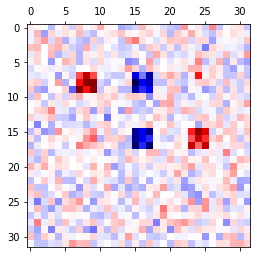

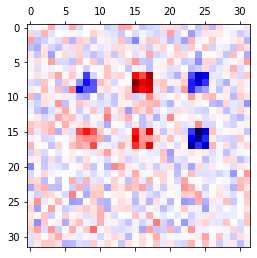

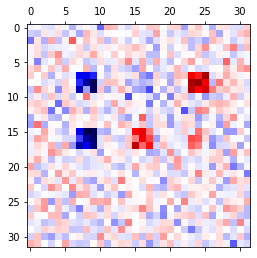

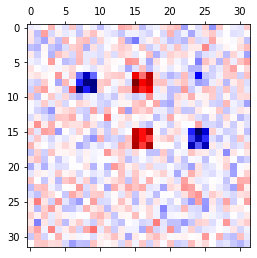

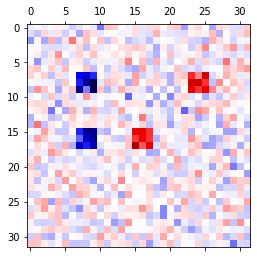

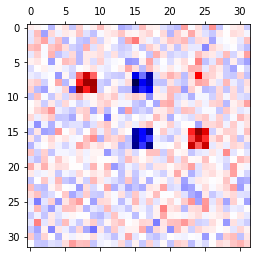

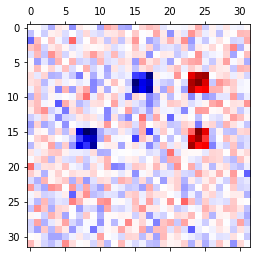

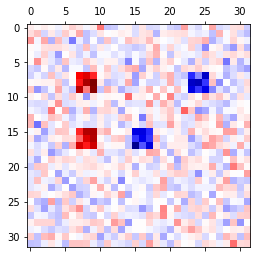

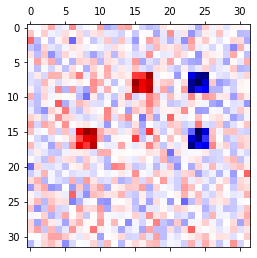

In [37]:
#Plot gradients for the structured linear model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sl_0[0][1]).max()
plt.matshow(np.reshape(grad_sl_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sl_1[0][1]).max()
plt.matshow(np.reshape(grad_sl_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sl_2[0][1]).max()
plt.matshow(np.reshape(grad_sl_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sl_0_1[0][1]).max()
plt.matshow(np.reshape(grad_sl_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sl_0_2[0][1]).max()
plt.matshow(np.reshape(grad_sl_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sl_1_0[0][1]).max()
plt.matshow(np.reshape(grad_sl_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sl_1_2[0][1]).max()
plt.matshow(np.reshape(grad_sl_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sl_2_0[0][1]).max()
plt.matshow(np.reshape(grad_sl_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sl_2_1[0][1]).max()
plt.matshow(np.reshape(grad_sl_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [38]:
#Train neural network model
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_nn, a_nn = sess.run([train_nn, loss_nn, acc_nn], feed_dict={x: train_data, y_true: train_labels})
        print('Loss L: ' + str(l_nn[0]))
        print('Acc L: ' + str(a_nn))
    saver_nn.save(sess, "saved_models/model_nn.ckpt", write_meta_graph=False)

Loss L: 0.6880825
Acc L: 0.3890909
Loss L: 0.67207927
Acc L: 0.43295455
Loss L: 0.6403946
Acc L: 0.4746591
Loss L: 0.60231787
Acc L: 0.5213636
Loss L: 0.56329
Acc L: 0.565
Loss L: 0.52316594
Acc L: 0.60886365
Loss L: 0.48113272
Acc L: 0.6531818
Loss L: 0.4394748
Acc L: 0.6939773
Loss L: 0.3992878
Acc L: 0.7377273
Loss L: 0.36137015
Acc L: 0.77613634
Loss L: 0.3262214
Acc L: 0.80977273
Loss L: 0.29619274
Acc L: 0.84420455
Loss L: 0.26933762
Acc L: 0.87363636
Loss L: 0.2446474
Acc L: 0.89670455
Loss L: 0.22219372
Acc L: 0.9178409
Loss L: 0.20194145
Acc L: 0.9368182
Loss L: 0.17967184
Acc L: 0.94943184
Loss L: 0.15996712
Acc L: 0.96102273
Loss L: 0.14262693
Acc L: 0.9693182
Loss L: 0.12736559
Acc L: 0.97670454
Loss L: 0.112917334
Acc L: 0.9825
Loss L: 0.098595195
Acc L: 0.9877273
Loss L: 0.086327545
Acc L: 0.99215907
Loss L: 0.07581734
Acc L: 0.99465907
Loss L: 0.06681574
Acc L: 0.9968182
Loss L: 0.059233196
Acc L: 0.9977273
Loss L: 0.052969366
Acc L: 0.99875
Loss L: 0.04723192
Acc L: 0.9

In [39]:
#Get validation results for the neural network model with different temperatures
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.10955937
Acc L: 1.0


In [40]:
#Get test results for the neural network model
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    l_nn, a_nn = sess.run([loss_nn, acc_nn], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_nn[0]))
    print('Acc L: ' + str(a_nn))

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt
Loss L: 0.032630693
Acc L: 1.0


In [41]:
#Get test data gradients for the neural network model

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_nn_0 = sess.run(g_nn, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    gradxi_nn_0 = grad_nn_0 * x_0
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_nn_1 = sess.run(g_nn, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    gradxi_nn_1 = grad_nn_1 * x_1
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_nn_2 = sess.run(g_nn, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    gradxi_nn_2 = grad_nn_2 * x_2
    
    #Get gradients for class 1 for class 0 inputs
    grad_nn_0_1 = sess.run(g_nn, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_nn_0_1 = grad_nn_0_1 * x_0
    
    #Get gradients for class 2 for class 0 inputs
    grad_nn_0_2 = sess.run(g_nn, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    gradxi_nn_0_2 = grad_nn_0_2 * x_0
    
    #Get gradients for class 0 for class 1 inputs 
    grad_nn_1_0 = sess.run(g_nn, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_nn_1_0 = grad_nn_1_0 * x_1
    
    #Get gradients for class 2 for class 1 inputs
    grad_nn_1_2 = sess.run(g_nn, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    gradxi_nn_1_2 = grad_nn_1_2 * x_1

    #Get gradients for class 0 for class 2 inputs
    grad_nn_2_0 = sess.run(g_nn, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    gradxi_nn_2_0 = grad_nn_2_0 * x_2
    
    #Get gradients for class 1 for class 2 inputs
    grad_nn_2_1 = sess.run(g_nn, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})
    
    gradxi_nn_2_1 = grad_nn_2_1 * x_2

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


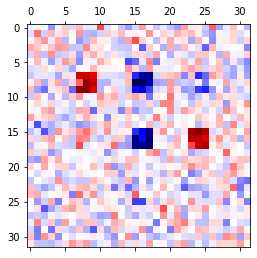

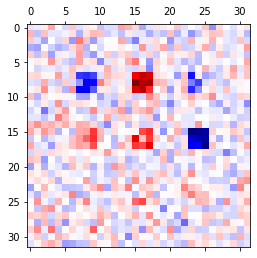

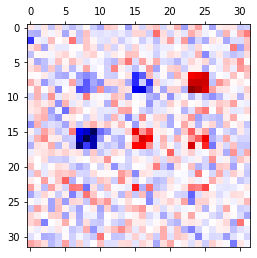

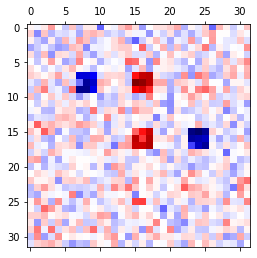

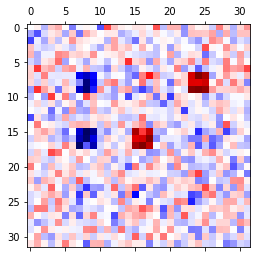

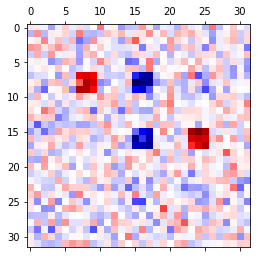

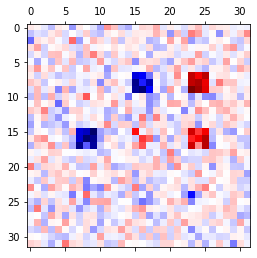

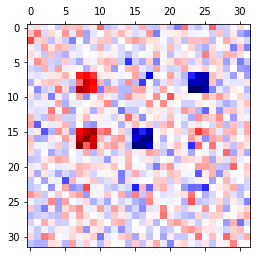

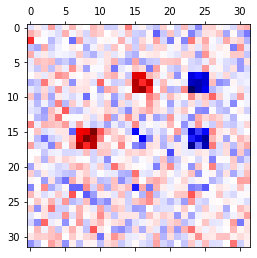

In [42]:
#Plot gradients for the neural network model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_nn_0[0][1]).max()
plt.matshow(np.reshape(grad_nn_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_nn_1[0][1]).max()
plt.matshow(np.reshape(grad_nn_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_nn_2[0][1]).max()
plt.matshow(np.reshape(grad_nn_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_nn_0_1[0][1]).max()
plt.matshow(np.reshape(grad_nn_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_nn_0_2[0][1]).max()
plt.matshow(np.reshape(grad_nn_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_nn_1_0[0][1]).max()
plt.matshow(np.reshape(grad_nn_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_nn_1_2[0][1]).max()
plt.matshow(np.reshape(grad_nn_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_nn_2_0[0][1]).max()
plt.matshow(np.reshape(grad_nn_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_nn_2_1[0][1]).max()
plt.matshow(np.reshape(grad_nn_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

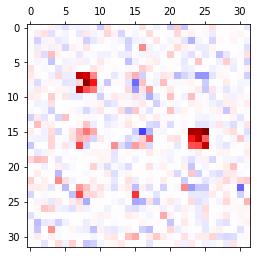

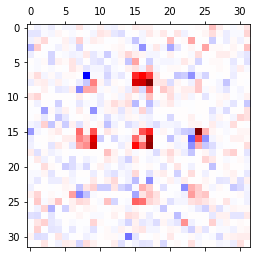

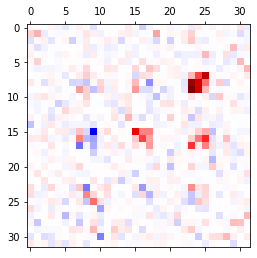

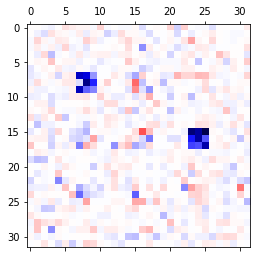

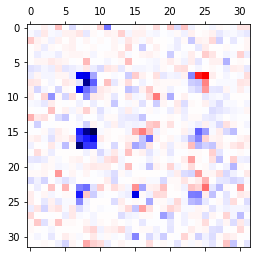

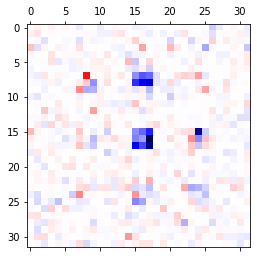

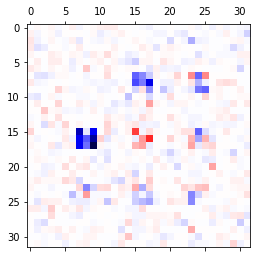

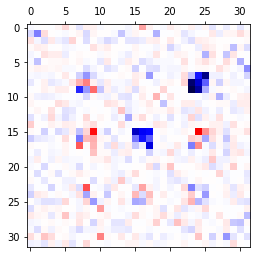

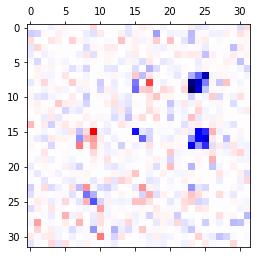

In [43]:
#Plot gradients for the neural network model

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(gradxi_nn_0[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(gradxi_nn_1[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(gradxi_nn_2[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(gradxi_nn_0_1[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(gradxi_nn_0_2[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(gradxi_nn_1_0[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(gradxi_nn_1_2[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(gradxi_nn_2_0[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(gradxi_nn_2_1[0][1]).max()
plt.matshow(np.reshape(gradxi_nn_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [44]:
#Get test data gradients for the neural network model with SmoothGrad

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_nn.restore(sess, "saved_models/model_nn.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: test_labels[where_test_0[0]]})[0])
    grad_sg_0 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: test_labels[where_test_1[0]]})[0])
    grad_sg_1 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]
    
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: test_labels[where_test_2[0]]})[0])
    grad_sg_2 = np.array(grads).mean(axis=0,keepdims=True) 
    
    #Get gradients for class 1 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_1 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 2 for class 0 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_0+np.random.normal(loc=0.0,scale=0.3,size=x_0.shape), y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)})[0])
    grad_sg_0_2 = np.array(grads).mean(axis=0,keepdims=True)  
    
    #Get gradients for class 0 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 2 for class 1 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_1+np.random.normal(loc=0.0,scale=0.3,size=x_1.shape), y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)})[0])
    grad_sg_1_2 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 0 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_0 = np.array(grads).mean(axis=0,keepdims=True)
    
    #Get gradients for class 1 for class 2 inputs
    grads = []
    for m in range(10):
        grads.append(sess.run(g_nn, feed_dict={x: x_2+np.random.normal(loc=0.0,scale=0.3,size=x_2.shape), y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})[0])
    grad_sg_2_1 = np.array(grads).mean(axis=0,keepdims=True)

INFO:tensorflow:Restoring parameters from saved_models/model_nn.ckpt


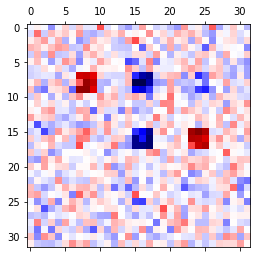

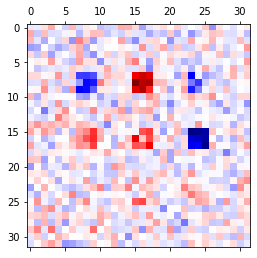

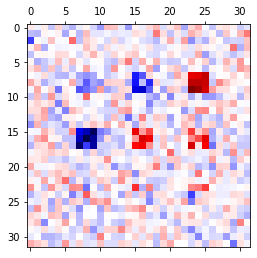

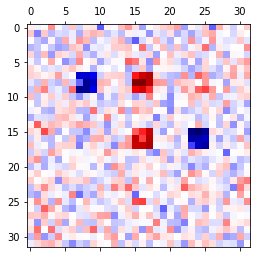

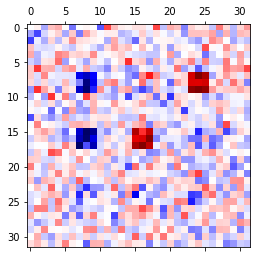

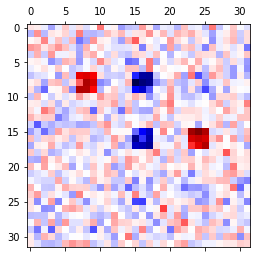

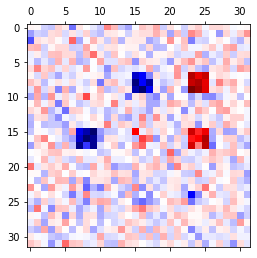

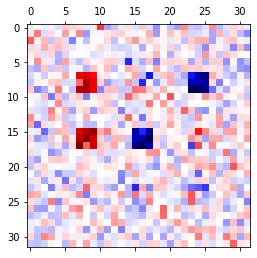

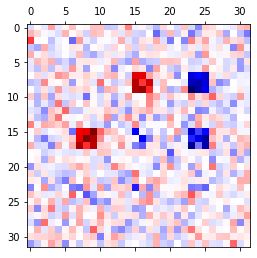

In [45]:
#Plot gradients for the neural network model with SmoothGrad

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sg_0[0][1]).max()
plt.matshow(np.reshape(grad_sg_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sg_1[0][1]).max()
plt.matshow(np.reshape(grad_sg_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sg_2[0][1]).max()
plt.matshow(np.reshape(grad_sg_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sg_0_1[0][1]).max()
plt.matshow(np.reshape(grad_sg_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sg_0_2[0][1]).max()
plt.matshow(np.reshape(grad_sg_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sg_1_0[0][1]).max()
plt.matshow(np.reshape(grad_sg_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sg_1_2[0][1]).max()
plt.matshow(np.reshape(grad_sg_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sg_2_0[0][1]).max()
plt.matshow(np.reshape(grad_sg_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sg_2_1[0][1]).max()
plt.matshow(np.reshape(grad_sg_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [46]:
#Define function to generate uniform spherical noise
def get_sph_noise(shape,epsilon):
    n_noise_samples = shape[0]
    shape.pop(0)
    noise = []
    for n in range(n_noise_samples):
        noise_tmp = np.random.normal(size=shape)
        u = np.random.uniform(size=())
        noise_tmp = (epsilon*(u**(1.0/float(np.prod(np.array(shape))))) * noise_tmp / (np.linalg.norm(noise_tmp)+1e-16))  
        noise.append(noise_tmp)
    return np.array(noise)

In [47]:
#Train neural network model with random spherical noise
n_ep = 100
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        noise = get_sph_noise(list(train_data.shape),1.0)
        _, l_sph, a_sph = sess.run([train_sph, loss_sph, acc_sph], feed_dict={x: train_data+noise, y_true: train_labels})
        print('Loss L: ' + str(l_sph[0]))
        print('Acc L: ' + str(a_sph))
    saver_sph.save(sess, "saved_models/model_sph.ckpt", write_meta_graph=False)

Loss L: 1.9870815
Acc L: 0.31602272
Loss L: 1.810457
Acc L: 0.33579546
Loss L: 1.6296818
Acc L: 0.3668182
Loss L: 1.4067378
Acc L: 0.39636365
Loss L: 1.3614666
Acc L: 0.43261364
Loss L: 1.1911848
Acc L: 0.47431818
Loss L: 0.9821701
Acc L: 0.51511365
Loss L: 0.8734193
Acc L: 0.5606818
Loss L: 0.8158398
Acc L: 0.6035227
Loss L: 0.8056071
Acc L: 0.64670455
Loss L: 0.7374593
Acc L: 0.6896591
Loss L: 0.6940234
Acc L: 0.73
Loss L: 0.6322964
Acc L: 0.76511365
Loss L: 0.63455194
Acc L: 0.79818183
Loss L: 0.56399256
Acc L: 0.82875
Loss L: 0.5520933
Acc L: 0.85829544
Loss L: 0.5108221
Acc L: 0.8798864
Loss L: 0.5172354
Acc L: 0.89772725
Loss L: 0.429023
Acc L: 0.91636366
Loss L: 0.4461055
Acc L: 0.9303409
Loss L: 0.40273252
Acc L: 0.9447727
Loss L: 0.34826872
Acc L: 0.9554545
Loss L: 0.33322147
Acc L: 0.9654545
Loss L: 0.30005285
Acc L: 0.97136366
Loss L: 0.27234888
Acc L: 0.9778409
Loss L: 0.24148026
Acc L: 0.98295456
Loss L: 0.22440323
Acc L: 0.9861364
Loss L: 0.16147698
Acc L: 0.98875
Loss L:

In [48]:
#Get validation results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.104722425
Acc L: 1.0


In [49]:
#Get test results for the neural network model trained with spherical noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    l_sph, a_sph = sess.run([loss_sph, acc_sph], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_sph[0]))
    print('Acc L: ' + str(a_sph))

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt
Loss L: 0.023895372
Acc L: 1.0


In [50]:
#Get test data gradients for the neural network model trained with spherical noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sph.restore(sess, "saved_models/model_sph.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_sph_0 = sess.run(g_sph, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_sph_1 = sess.run(g_sph, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_sph_2 = sess.run(g_sph, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_sph_0_1 = sess.run(g_sph, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_sph_0_2 = sess.run(g_sph, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_sph_1_0 = sess.run(g_sph, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_sph_1_2 = sess.run(g_sph, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_sph_2_0 = sess.run(g_sph, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_sph_2_1 = sess.run(g_sph, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_sph.ckpt


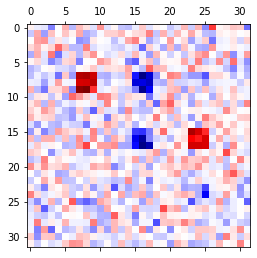

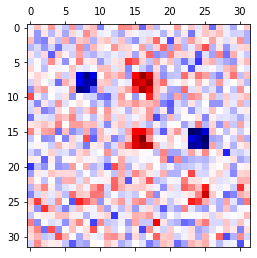

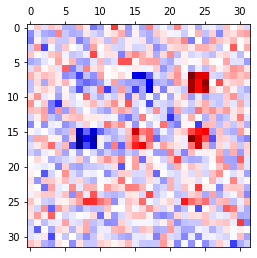

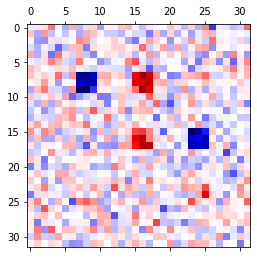

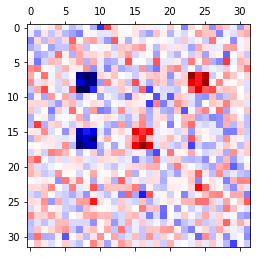

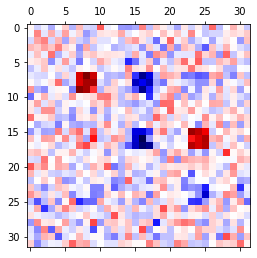

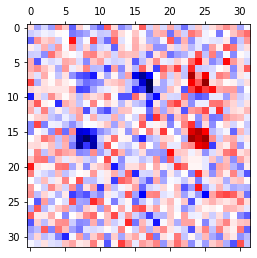

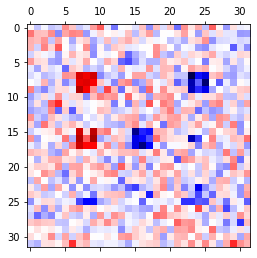

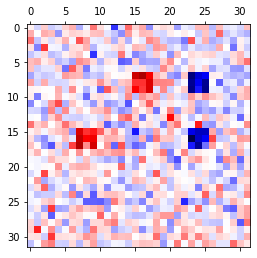

In [51]:
#Plot gradients for the neural network model trained with spherical noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sph_0[0][1]).max()
plt.matshow(np.reshape(grad_sph_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sph_1[0][1]).max()
plt.matshow(np.reshape(grad_sph_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sph_2[0][1]).max()
plt.matshow(np.reshape(grad_sph_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sph_0_1[0][1]).max()
plt.matshow(np.reshape(grad_sph_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sph_0_2[0][1]).max()
plt.matshow(np.reshape(grad_sph_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sph_1_0[0][1]).max()
plt.matshow(np.reshape(grad_sph_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sph_1_2[0][1]).max()
plt.matshow(np.reshape(grad_sph_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sph_2_0[0][1]).max()
plt.matshow(np.reshape(grad_sph_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sph_2_1[0][1]).max()
plt.matshow(np.reshape(grad_sph_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [52]:
#Train neural network model with adversarial noise
n_ep = 50
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_sla, a_sla, grads_sla = sess.run([train_sla, loss_sla, acc_sla, g_sla], feed_dict={x: train_data, y_true: train_labels})
        del_1 = grads_sla[0]
        norm_del_1 = np.linalg.norm(del_1,axis=(1,2))
        norm_where = np.where(norm_del_1>0.0)
        norm_del_1 = np.reshape(norm_del_1,(-1,1,1))
        del_1[norm_where] = del_1[norm_where] / norm_del_1[norm_where]
        del_1 *= -1.0
        del_2 = sess.run(g_sla, feed_dict={x: train_data + del_1, y_true: train_labels})[0]
        norm_del_2 = np.linalg.norm(del_2,axis=(1,2))
        norm_where = np.where(norm_del_2>0.0)
        norm_del_2 = np.reshape(norm_del_2,(-1,1,1))
        del_2[norm_where] = del_2[norm_where] / norm_del_2[norm_where]
        del_2 = del_1 - 1.0 * del_2
        del_3 = sess.run(g_sla, feed_dict={x: train_data + del_2, y_true: train_labels})[0]
        norm_del_3 = np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>0.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        del_3[norm_where] = del_3[norm_where] / norm_del_3[norm_where]
        del_3 = del_2 - 1.0 * del_3
        norm_del_3 =  np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>1.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        if len(norm_where) > 0:
            del_3[norm_where] = 1.0 * del_3[norm_where] / norm_del_3[norm_where] 
        _ = sess.run(train_sla, feed_dict={x: (train_data + del_3), y_true: train_labels})
        print('Loss L: ' + str(l_sla[0]))
        print('Acc L: ' + str(a_sla))
    saver_sla.save(sess, "saved_models/model_sla.ckpt", write_meta_graph=False)

Loss L: 3.1418812
Acc L: 0.36818182
Loss L: 2.7340147
Acc L: 0.4156818
Loss L: 2.3987722
Acc L: 0.47625
Loss L: 2.115568
Acc L: 0.5459091
Loss L: 1.8440475
Acc L: 0.6242045
Loss L: 1.5893584
Acc L: 0.6989773
Loss L: 1.3601959
Acc L: 0.7679545
Loss L: 1.1519121
Acc L: 0.83590907
Loss L: 1.0104264
Acc L: 0.8921591
Loss L: 0.89213556
Acc L: 0.93238634
Loss L: 0.7945748
Acc L: 0.96090907
Loss L: 0.69817597
Acc L: 0.9771591
Loss L: 0.6132438
Acc L: 0.9865909
Loss L: 0.5389447
Acc L: 0.9952273
Loss L: 0.4725291
Acc L: 0.9982954
Loss L: 0.412007
Acc L: 0.9990909
Loss L: 0.3564524
Acc L: 0.99965906
Loss L: 0.3057286
Acc L: 0.99988633
Loss L: 0.25284725
Acc L: 0.99988633
Loss L: 0.19883358
Acc L: 1.0
Loss L: 0.15356897
Acc L: 1.0
Loss L: 0.11878897
Acc L: 1.0
Loss L: 0.09250855
Acc L: 1.0
Loss L: 0.07284509
Acc L: 1.0
Loss L: 0.058140304
Acc L: 1.0
Loss L: 0.047121726
Acc L: 1.0
Loss L: 0.038927082
Acc L: 1.0
Loss L: 0.03260219
Acc L: 1.0
Loss L: 0.027649837
Acc L: 1.0
Loss L: 0.02370994
Acc L:

In [53]:
#Get validation results for the structured linear model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sla.restore(sess, "saved_models/model_sla.ckpt")
    l_sla, a_sla = sess.run([loss_sla, acc_sla], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_sla[0]))
    print('Acc L: ' + str(a_sla))

INFO:tensorflow:Restoring parameters from saved_models/model_sla.ckpt
Loss L: 0.020836273
Acc L: 1.0


In [54]:
#Get test results for the structured linear model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sla.restore(sess, "saved_models/model_sla.ckpt")
    l_sla, a_sla = sess.run([loss_sla, acc_sla], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_sla[0]))
    print('Acc L: ' + str(a_sla))

INFO:tensorflow:Restoring parameters from saved_models/model_sla.ckpt
Loss L: 0.022182208
Acc L: 1.0


In [55]:
#Get test data gradients for the structured linear model trained with adversarial noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_sla.restore(sess, "saved_models/model_sla.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_sla_0 = sess.run(g_sla, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_sla_1 = sess.run(g_sla, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_sla_2 = sess.run(g_sla, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_sla_0_1 = sess.run(g_sla, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_sla_0_2 = sess.run(g_sla, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_sla_1_0 = sess.run(g_sla, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_sla_1_2 = sess.run(g_sla, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_sla_2_0 = sess.run(g_sla, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_sla_2_1 = sess.run(g_sla, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_sla.ckpt


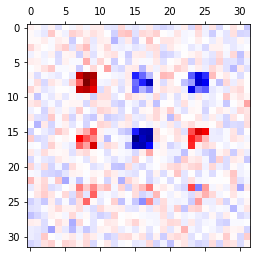

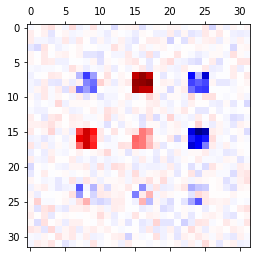

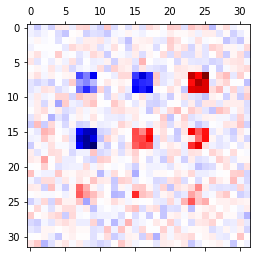

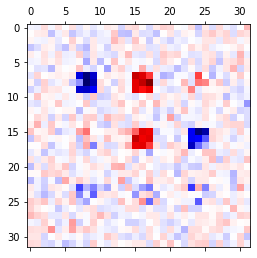

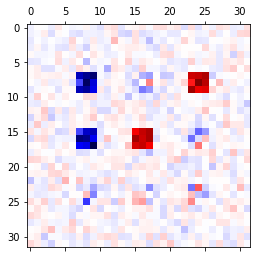

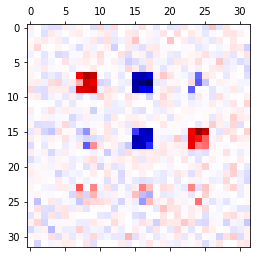

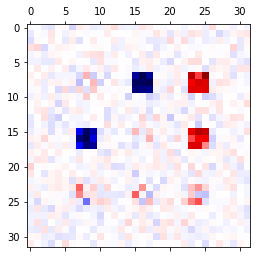

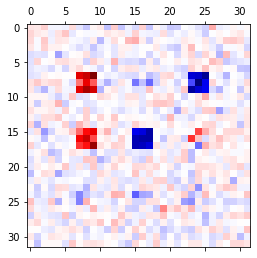

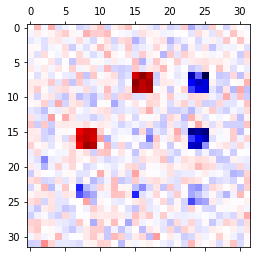

In [56]:
#Plot gradients for the structured model trained with adversarial noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_sla_0[0][1]).max()
plt.matshow(np.reshape(grad_sla_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_sla_1[0][1]).max()
plt.matshow(np.reshape(grad_sla_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_sla_2[0][1]).max()
plt.matshow(np.reshape(grad_sla_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_sla_0_1[0][1]).max()
plt.matshow(np.reshape(grad_sla_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_sla_0_2[0][1]).max()
plt.matshow(np.reshape(grad_sla_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_sla_1_0[0][1]).max()
plt.matshow(np.reshape(grad_sla_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_sla_1_2[0][1]).max()
plt.matshow(np.reshape(grad_sla_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_sla_2_0[0][1]).max()
plt.matshow(np.reshape(grad_sla_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_sla_2_1[0][1]).max()
plt.matshow(np.reshape(grad_sla_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [57]:
#Train neural network model with adversarial noise
n_ep = 50
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for ep in range(n_ep):
        _, l_adv, a_adv, grads_adv = sess.run([train_adv, loss_adv, acc_adv, g_adv], feed_dict={x: train_data, y_true: train_labels})
        del_1 = grads_adv[0]
        norm_del_1 = np.linalg.norm(del_1,axis=(1,2))
        norm_where = np.where(norm_del_1>0.0)
        norm_del_1 = np.reshape(norm_del_1,(-1,1,1))
        del_1[norm_where] = del_1[norm_where] / norm_del_1[norm_where]
        del_1 *= -1.0
        del_2 = sess.run(g_adv, feed_dict={x: train_data + del_1, y_true: train_labels})[0]
        norm_del_2 = np.linalg.norm(del_2,axis=(1,2))
        norm_where = np.where(norm_del_2>0.0)
        norm_del_2 = np.reshape(norm_del_2,(-1,1,1))
        del_2[norm_where] = del_2[norm_where] / norm_del_2[norm_where]
        del_2 = del_1 - 1.0 * del_2
        del_3 = sess.run(g_adv, feed_dict={x: train_data + del_2, y_true: train_labels})[0]
        norm_del_3 = np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>0.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        del_3[norm_where] = del_3[norm_where] / norm_del_3[norm_where]
        del_3 = del_2 - 1.0 * del_3
        norm_del_3 =  np.linalg.norm(del_3,axis=(1,2))
        norm_where = np.where(norm_del_3>1.0)
        norm_del_3 = np.reshape(norm_del_3,(-1,1,1))
        if len(norm_where) > 0:
            del_3[norm_where] = 1.0 * del_3[norm_where] / norm_del_3[norm_where] 
        _ = sess.run(train_adv, feed_dict={x: (train_data + del_3), y_true: train_labels})
        print('Loss L: ' + str(l_adv[0]))
        print('Acc L: ' + str(a_adv))
    saver_adv.save(sess, "saved_models/model_adv.ckpt", write_meta_graph=False)

Loss L: 0.8215742
Acc L: 0.28318182
Loss L: 0.80369943
Acc L: 0.34113637
Loss L: 0.78980184
Acc L: 0.42079544
Loss L: 0.7788708
Acc L: 0.51295453
Loss L: 0.7701001
Acc L: 0.6134091
Loss L: 0.76242894
Acc L: 0.7053409
Loss L: 0.75460756
Acc L: 0.7875
Loss L: 0.7457995
Acc L: 0.8521591
Loss L: 0.7318979
Acc L: 0.90125
Loss L: 0.7097025
Acc L: 0.94125
Loss L: 0.6746364
Acc L: 0.9672727
Loss L: 0.63905466
Acc L: 0.9840909
Loss L: 0.5951327
Acc L: 0.99204546
Loss L: 0.5209353
Acc L: 0.99613637
Loss L: 0.45127413
Acc L: 0.9981818
Loss L: 0.38748696
Acc L: 0.99863636
Loss L: 0.33039626
Acc L: 0.99954545
Loss L: 0.2800297
Acc L: 1.0
Loss L: 0.2362074
Acc L: 1.0
Loss L: 0.19505459
Acc L: 1.0
Loss L: 0.15735629
Acc L: 1.0
Loss L: 0.12691188
Acc L: 1.0
Loss L: 0.102525204
Acc L: 1.0
Loss L: 0.08310836
Acc L: 1.0
Loss L: 0.06775161
Acc L: 1.0
Loss L: 0.055614278
Acc L: 1.0
Loss L: 0.04603088
Acc L: 1.0
Loss L: 0.038444024
Acc L: 1.0
Loss L: 0.03239563
Acc L: 1.0
Loss L: 0.027548136
Acc L: 1.0
Loss

In [58]:
#Get validation results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: val_data, y_true: val_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.059504043
Acc L: 1.0


In [59]:
#Get test results for the neural network model trained with adversarial noise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    l_adv, a_adv = sess.run([loss_adv, acc_adv], feed_dict={x: test_data, y_true: test_labels})
    print('Loss L: ' + str(l_adv[0]))
    print('Acc L: ' + str(a_adv))

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt
Loss L: 0.024432505
Acc L: 1.0


In [60]:
#Get test data gradients for the neural network model trained with adversarial noise

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver_adv.restore(sess, "saved_models/model_adv.ckpt")
    #Get gradients for class 0 for class 0 inputs
    x_0 = test_data[where_test_0[0],:,:]
    
    grad_adv_0 = sess.run(g_adv, feed_dict={x: x_0, y_true: test_labels[where_test_0[0]]}) 
    
    #Get gradients for class 1 for class 1 inputs
    x_1 =test_data[where_test_1[0],:,:]
    
    grad_adv_1 = sess.run(g_adv, feed_dict={x: x_1, y_true: test_labels[where_test_1[0]]})
    
    #Get gradients for class 2 for class 2 inputs
    x_2 =test_data[where_test_2[0],:,:]

    grad_adv_2 = sess.run(g_adv, feed_dict={x: x_2, y_true: test_labels[where_test_2[0]]})
    
    #Get gradients for class 1 for class 0 inputs
    grad_adv_0_1 = sess.run(g_adv, feed_dict={x: x_0, y_true: 1.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 2 for class 0 inputs
    grad_adv_0_2 = sess.run(g_adv, feed_dict={x: x_0, y_true: 2.0*np.ones(test_labels[where_test_0[0]].shape)}) 
    
    #Get gradients for class 0 for class 1 inputs 
    grad_adv_1_0 = sess.run(g_adv, feed_dict={x: x_1, y_true: 0.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 2 for class 1 inputs
    grad_adv_1_2 = sess.run(g_adv, feed_dict={x: x_1, y_true: 2.0*np.ones(test_labels[where_test_1[0]].shape)}) 
    
    #Get gradients for class 0 for class 2 inputs
    grad_adv_2_0 = sess.run(g_adv, feed_dict={x: x_2, y_true: 0.0*np.ones(test_labels[where_test_2[0]].shape)}) 
    
    #Get gradients for class 1 for class 2 inputs
    grad_adv_2_1 = sess.run(g_adv, feed_dict={x: x_2, y_true: 1.0*np.ones(test_labels[where_test_2[0]].shape)})

INFO:tensorflow:Restoring parameters from saved_models/model_adv.ckpt


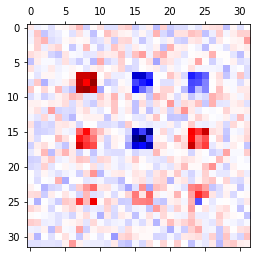

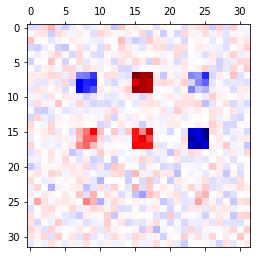

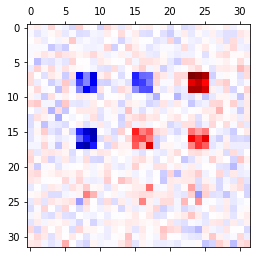

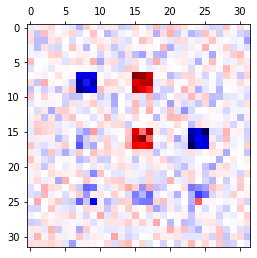

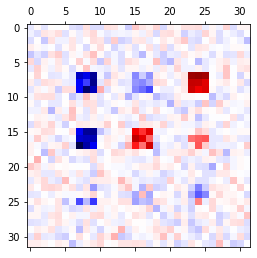

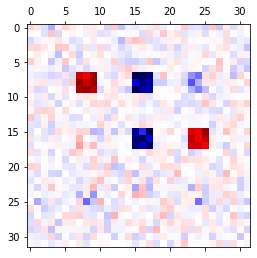

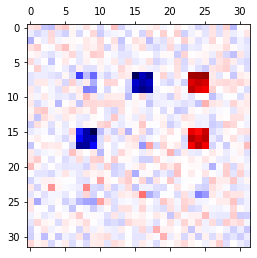

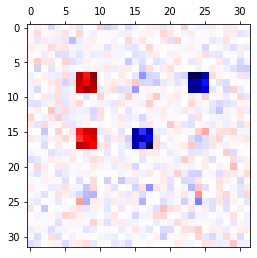

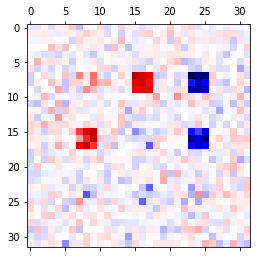

In [61]:
#Plot gradients for the neural network model trained with adversarial noise

#Plot gradients for class 0 for class 0 inputs
clim = np.abs(grad_adv_0[0][1]).max()
plt.matshow(np.reshape(grad_adv_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 1 inputs
clim = np.abs(grad_adv_1[0][1]).max()
plt.matshow(np.reshape(grad_adv_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradientws for class 2 for class 2 inputs
clim = np.abs(grad_adv_2[0][1]).max()
plt.matshow(np.reshape(grad_adv_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 0 inputs
clim = np.abs(grad_adv_0_1[0][1]).max()
plt.matshow(np.reshape(grad_adv_0_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 0 inputs
clim = np.abs(grad_adv_0_2[0][1]).max()
plt.matshow(np.reshape(grad_adv_0_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 1 inputs
clim = np.abs(grad_adv_1_0[0][1]).max()
plt.matshow(np.reshape(grad_adv_1_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 2 for class 1 inputs
clim = np.abs(grad_adv_1_2[0][1]).max()
plt.matshow(np.reshape(grad_adv_1_2[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 0 for class 2 inputs
clim = np.abs(grad_adv_2_0[0][1]).max()
plt.matshow(np.reshape(grad_adv_2_0[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

#Plot gradients for class 1 for class 2 inputs
clim = np.abs(grad_adv_2_1[0][1]).max()
plt.matshow(np.reshape(grad_adv_2_1[0][1],[32,32]),cmap='seismic',vmin=-1.0*clim,vmax=clim)

In [62]:
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

In [63]:
#Correlation between the class 0 template minus the average template and the class 0 correlation gradient for class 0 inputs
pearsonr(np.reshape(grad_c_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.9942566667720458, 0.0)

In [64]:
#Correlation between the class 0 template minus the average template and the class 0 weights
pearsonr(np.reshape(weights_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.44134382935042615, 4.695979125376905e-50)

In [65]:
#Correlation between the class 0 template minus the average template and the average class 0 linear model gradient for class 0 inputs
pearsonr(np.reshape(grad_l_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.6046128767047165, 4.341261385898672e-103)

In [66]:
#Correlation between the class 0 template minus the average template and the average class 0 linear model gradient for class 0 inputs
pearsonr(np.reshape(grad_sl_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7449900398788962, 6.78449400157127e-182)

In [67]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network gradient for class 0 inputs
pearsonr(np.reshape(grad_nn_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7072793290129996, 4.0965617135077304e-156)

In [68]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network gradientxinput for class 0 inputs
pearsonr(np.reshape(gradxi_nn_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.6872520810996244, 4.929906150229198e-144)

In [69]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network trained with spherical noise gradient for class 0 inputs
pearsonr(np.reshape(grad_sph_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7021318859611773, 6.517118021073077e-153)

In [70]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network SmoothGrad gradient for class 0 inputs
pearsonr(np.reshape(grad_sg_0.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.7115991893323744, 7.432227099507455e-159)

In [71]:
#Correlation between the class 0 template minus the average template and the average class 0 linear model gradient for class 0 inputs
pearsonr(np.reshape(grad_sla_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.8967121155531592, 0.0)

In [72]:
#Correlation between the class 0 template minus the average template and the average class 0 neural network with adversarial training gradient for class 0 inputs
pearsonr(np.reshape(grad_adv_0[0].mean(axis=0),(-1)),np.reshape(diff_0,(-1)))

(0.9101810456414144, 0.0)

In [73]:
#Correlation between the class 1 template minus the average template and the average class 1 correlation model gradient for class 1 inputs
pearsonr(np.reshape(grad_c_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.9946208524333654, 0.0)

In [74]:
#Correlation between the class 1 template minus the average template and the class 1 weights
pearsonr(np.reshape(weights_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.41440436134203723, 9.188779627939842e-44)

In [75]:
#Correlation between the class 1 template minus the average template and the average class 1 linear model gradient for class 1 inputs
pearsonr(np.reshape(grad_l_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.6132283025889254, 8.52512152387942e-107)

In [76]:
#Correlation between the class 1 template minus the average template and the average class 1 linear model gradient for class 1 inputs
pearsonr(np.reshape(grad_sl_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7416327682513015, 2.0357151722334448e-179)

In [77]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network gradient for class 1 inputs
pearsonr(np.reshape(grad_nn_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.737613286752667, 1.6759216846997706e-176)

In [78]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network gradientxinput for class 1 inputs
pearsonr(np.reshape(gradxi_nn_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.6525937596790248, 2.708933911416148e-125)

In [79]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network trained with spherical noise gradient for class 1 inputs
pearsonr(np.reshape(grad_sph_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.6686572279471923, 1.1555548211466534e-133)

In [80]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network SmoothGrad gradient for class 1 inputs
pearsonr(np.reshape(grad_sg_1.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.7384891774874995, 3.9221002772977733e-177)

In [81]:
#Correlation between the class 1 template minus the average template and the average class 1 linear model gradient for class 1 inputs
pearsonr(np.reshape(grad_sla_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.8943318286163875, 0.0)

In [82]:
#Correlation between the class 1 template minus the average template and the average class 1 neural network with adversarial training gradient for class 1 inputs
pearsonr(np.reshape(grad_adv_1[0].mean(axis=0),(-1)),np.reshape(diff_1,(-1)))

(0.9450710000639689, 0.0)

In [83]:
#Correlation between the class 2 template minus the average template and the average class 2 correlation model gradient for class 2 inputs
pearsonr(np.reshape(grad_c_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.9942925417502901, 0.0)

In [84]:
#Correlation between the class 2 template minus the average template and the class 2 weights
pearsonr(np.reshape(weights_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.37311041399121747, 3.58762261948521e-35)

In [85]:
#Correlation between the class 2 template minus the average template and the average class 2 linear model gradient for class 2 inputs
pearsonr(np.reshape(grad_l_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.5161367028785596, 8.585701811534355e-71)

In [86]:
#Correlation between the class 2 template minus the average template and the average class 2 linear model gradient for class 2 inputs
pearsonr(np.reshape(grad_sl_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.7301680923421849, 3.0557209745070963e-171)

In [87]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network gradient for class 2 inputs
pearsonr(np.reshape(grad_nn_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.7340955405411065, 5.396346964284798e-174)

In [88]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network gradientxinput for class 2 inputs
pearsonr(np.reshape(gradxi_nn_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.6762473062540848, 8.361978941292701e-138)

In [89]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network trained with spherical noise gradient for class 2 inputs
pearsonr(np.reshape(grad_sph_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.6901750839029074, 9.800098826807272e-146)

In [90]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network SmoothGrad gradient for class 2 inputs
pearsonr(np.reshape(grad_sg_2.mean(axis=0).mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.7335234682223837, 1.3682108011302993e-173)

In [91]:
#Correlation between the class 2 template minus the average template and the average class 2 linear model gradient for class 2 inputs
pearsonr(np.reshape(grad_sla_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.9164525385025013, 0.0)

In [92]:
#Correlation between the class 2 template minus the average template and the average class 2 neural network with adversarial training gradient for class 2 inputs
pearsonr(np.reshape(grad_adv_2[0].mean(axis=0),(-1)),np.reshape(diff_2,(-1)))

(0.930056345695158, 0.0)

In [93]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_c = []
for i in range(grad_c_0[0].shape[0]):
    corrs_grad_c.append(pearsonr(np.reshape(grad_c_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_c_1[0].shape[0]):
    corrs_grad_c.append(pearsonr(np.reshape(grad_c_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_c_2[0].shape[0]):
    corrs_grad_c.append(pearsonr(np.reshape(grad_c_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [94]:
np.array(corrs_grad_c).mean()

0.97841522957206

In [95]:
#Get the correlation between the class template minus the average template and the respective weights for each input
corrs_weights = []
for i in range(weights_l_0[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(weights_l_1[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(weights_l_2[0].shape[0]):
    corrs_weights.append(pearsonr(np.reshape(weights_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [96]:
np.array(corrs_weights).mean()

0.4129532202087928

In [97]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_l = []
for i in range(grad_l_0[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_l_1[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_l_2[0].shape[0]):
    corrs_grad_l.append(pearsonr(np.reshape(grad_l_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [98]:
np.array(corrs_grad_l).mean()

0.5738277718504358

In [99]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_sl = []
for i in range(grad_sl_0[0].shape[0]):
    corrs_grad_sl.append(pearsonr(np.reshape(grad_sl_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sl_1[0].shape[0]):
    corrs_grad_sl.append(pearsonr(np.reshape(grad_sl_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sl_2[0].shape[0]):
    corrs_grad_sl.append(pearsonr(np.reshape(grad_sl_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [100]:
np.array(corrs_grad_sl).mean()

0.7154413876521908

In [101]:
#Get the correlation between the class template minus the average template and the respective neural network gradient for each input
corrs_grad_nn = []
for i in range(grad_nn_0[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_nn_1[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_nn_2[0].shape[0]):
    corrs_grad_nn.append(pearsonr(np.reshape(grad_nn_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [102]:
np.array(corrs_grad_nn).mean()

0.6561355204811098

In [103]:
#Get the correlation between the class template minus the average template and the respective neural network gradient for each input
corrs_gradxi_nn = []
for i in range(gradxi_nn_0[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(gradxi_nn_1[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(gradxi_nn_2[0].shape[0]):
    corrs_gradxi_nn.append(pearsonr(np.reshape(gradxi_nn_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [104]:
np.array(corrs_gradxi_nn).mean()

0.45869425822955007

In [105]:
#Get the correlation between the class template minus the average template and the respective neural network trained with spherical noise gradient for each input
corrs_grad_sph = []
for i in range(grad_sph_0[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sph_1[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sph_2[0].shape[0]):
    corrs_grad_sph.append(pearsonr(np.reshape(grad_sph_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [106]:
np.array(corrs_grad_sph).mean()

0.6115773502029151

In [107]:
#Get the correlation between the class template minus the average template and the respective neural network SmoothGrad gradient for each input
corrs_grad_sg = []
for i in range(grad_sg_0[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sg_1[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sg_2[0].shape[0]):
    corrs_grad_sg.append(pearsonr(np.reshape(grad_sg_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [108]:
np.array(corrs_grad_sg).mean()

0.6713132564792312

In [109]:
#Get the correlation between the class template minus the average template and the respective linear model gradient for each input
corrs_grad_sla = []
for i in range(grad_sla_0[0].shape[0]):
    corrs_grad_sla.append(pearsonr(np.reshape(grad_sla_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_sla_1[0].shape[0]):
    corrs_grad_sla.append(pearsonr(np.reshape(grad_sla_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_sla_2[0].shape[0]):
    corrs_grad_sla.append(pearsonr(np.reshape(grad_sla_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [110]:
np.array(corrs_grad_sla).mean()

0.8220718345089904

In [111]:
#Get the correlation between the class template minus the average template and the respective neural network with adversarial training gradient for each input
corrs_grad_adv = []
for i in range(grad_adv_0[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_0[0][i],(-1)),np.reshape(diff_0,(-1)))[0])
for i in range(grad_adv_1[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_1[0][i],(-1)),np.reshape(diff_1,(-1)))[0])
for i in range(grad_adv_2[0].shape[0]):
    corrs_grad_adv.append(pearsonr(np.reshape(grad_adv_2[0][i],(-1)),np.reshape(diff_2,(-1)))[0])

In [112]:
np.array(corrs_grad_adv).mean()

0.8393420253771616

In [113]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_weights)

Ttest_relResult(statistic=203.23733280690936, pvalue=1.3920951679765493e-131)

In [114]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_l)

Ttest_relResult(statistic=88.62376157878461, pvalue=4.100979000597397e-96)

In [115]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_sl)

Ttest_relResult(statistic=101.9512011316224, pvalue=4.511848355441361e-102)

In [116]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_sla)

Ttest_relResult(statistic=28.498798460342552, pvalue=1.6254688730491004e-49)

In [117]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_nn)

Ttest_relResult(statistic=55.812252954245245, pvalue=1.2439527017785679e-76)

In [118]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_gradxi_nn)

Ttest_relResult(statistic=74.1646787095522, pvalue=1.4380100429080185e-88)

In [119]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_sg)

Ttest_relResult(statistic=66.19652914215685, pvalue=8.887018712748091e-84)

In [120]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_sph)

Ttest_relResult(statistic=60.77578959188778, pvalue=3.4250357635199914e-80)

In [121]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c,corrs_grad_adv)

Ttest_relResult(statistic=17.810001064233187, pvalue=1.2284787441262869e-32)

In [122]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights,corrs_grad_l)

Ttest_relResult(statistic=-57.81426771216448, pvalue=4.209488288795393e-78)

In [123]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights,corrs_grad_sl)

Ttest_relResult(statistic=-99.70913455795193, pvalue=3.9930643038795916e-101)

In [124]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights,corrs_grad_sla)

Ttest_relResult(statistic=-59.6585299986421, pvalue=2.0484193744252688e-79)

In [125]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights,corrs_grad_nn)

Ttest_relResult(statistic=-32.87554082687214, pvalue=4.477848926565255e-55)

In [126]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network gradientsxinputs
ttest_rel(corrs_weights,corrs_gradxi_nn)

Ttest_relResult(statistic=-5.701227762163017, pvalue=1.2323760482912757e-07)

In [127]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights,corrs_grad_sph)

Ttest_relResult(statistic=-29.885125932218283, pvalue=2.3953848607256905e-51)

In [128]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network SmoothGrad gradients
ttest_rel(corrs_weights,corrs_grad_sg)

Ttest_relResult(statistic=-40.620202923452005, pvalue=1.5179475345172342e-63)

In [129]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network with adversarial training gradients
ttest_rel(corrs_weights,corrs_grad_sph)

Ttest_relResult(statistic=-29.885125932218283, pvalue=2.3953848607256905e-51)

In [130]:
#Perform a paired t-test of the respective template correlation across inputs for the weights and the neural network with adversarial training gradients
ttest_rel(corrs_weights,corrs_grad_adv)

Ttest_relResult(statistic=-44.82734301448882, pvalue=1.4474404588403367e-67)

In [131]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l,corrs_grad_sl)

Ttest_relResult(statistic=-35.66460036766781, pvalue=2.631021317173214e-58)

In [132]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l,corrs_grad_sla)

Ttest_relResult(statistic=-34.136902104200026, pvalue=1.452947003141744e-56)

In [133]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l,corrs_grad_nn)

Ttest_relResult(statistic=-10.266815976668232, pvalue=2.865734161507968e-17)

In [134]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradientsxinputs and the neural network gradients
ttest_rel(corrs_grad_l,corrs_gradxi_nn)

Ttest_relResult(statistic=12.863451176805533, pvalue=7.564152384934983e-23)

In [135]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l,corrs_grad_sg)

Ttest_relResult(statistic=-13.489196156879792, pvalue=3.725738173133911e-24)

In [136]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l,corrs_grad_sph)

Ttest_relResult(statistic=-4.461005352778799, pvalue=2.1589732753029744e-05)

In [137]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l,corrs_grad_adv)

Ttest_relResult(statistic=-27.49021154262683, pvalue=3.8731537499409244e-48)

In [138]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_grad_sla)

Ttest_relResult(statistic=-19.504502721975076, pvalue=1.0974380538131258e-35)

In [139]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_grad_nn)

Ttest_relResult(statistic=10.015877618888542, pvalue=1.0101215886569467e-16)

In [140]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_gradxi_nn)

Ttest_relResult(statistic=35.01506906315181, pvalue=1.422014582782548e-57)

In [141]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_grad_sg)

Ttest_relResult(statistic=9.042643171025707, pvalue=1.3381058791765565e-14)

In [142]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_grad_sph)

Ttest_relResult(statistic=15.698939520552083, pvalue=1.2826237935110706e-28)

In [143]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl,corrs_grad_adv)

Ttest_relResult(statistic=-15.105202665475433, pvalue=1.9154910841835202e-27)

In [144]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sla,corrs_grad_nn)

Ttest_relResult(statistic=29.305834658372692, pvalue=1.3688093965131723e-50)

In [145]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sla,corrs_gradxi_nn)

Ttest_relResult(statistic=47.47740874688831, pvalue=6.307745790185517e-70)

In [146]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sla,corrs_grad_sg)

Ttest_relResult(statistic=30.835257643866566, pvalue=1.4554123370971174e-52)

In [147]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sla,corrs_grad_sph)

Ttest_relResult(statistic=25.100220713971687, pvalue=1.0288522451213892e-44)

In [148]:
#Perform a paired t-test of the respective template correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sla,corrs_grad_adv)

Ttest_relResult(statistic=-2.7129568689341625, pvalue=0.007865534349423551)

In [149]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_nn,corrs_gradxi_nn)

Ttest_relResult(statistic=28.002716373892977, pvalue=7.646912968837555e-49)

In [150]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn,corrs_grad_sg)

Ttest_relResult(statistic=-5.517688292434073, pvalue=2.754414313265566e-07)

In [151]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn,corrs_grad_sph)

Ttest_relResult(statistic=5.345331194469248, pvalue=5.795214711553287e-07)

In [152]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn,corrs_grad_adv)

Ttest_relResult(statistic=-26.426963773963855, pvalue=1.209466335535145e-46)

In [153]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_sg)

Ttest_relResult(statistic=-31.896155843187337, pvalue=6.923287158907327e-54)

In [154]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_sph)

Ttest_relResult(statistic=-16.905770870816138, pvalue=6.034707544539459e-31)

In [155]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network gradientsxinputs and the neural network with adversarial training gradients
ttest_rel(corrs_gradxi_nn,corrs_grad_adv)

Ttest_relResult(statistic=-41.45671165896607, pvalue=2.2543339525264826e-64)

In [156]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg,corrs_grad_sph)

Ttest_relResult(statistic=8.01696179959425, pvalue=2.20766649529652e-12)

In [157]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg,corrs_grad_adv)

Ttest_relResult(statistic=-26.139325123145206, pvalue=3.1241376260470815e-46)

In [158]:
#Perform a paired t-test of the respective template correlation across inputs for the neural network trained with spherical gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph,corrs_grad_adv)

Ttest_relResult(statistic=-20.811007858744944, pvalue=6.224516801253114e-38)

In [159]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_c_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_c_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_c_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_c_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_c_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_c_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.8741077877384983

In [160]:
#Get average correlation between the incorrect class weights and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(weights_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(weights_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(weights_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(weights_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.35474092363135273

In [161]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_l_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_l_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_l_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_l_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.5808820307655713

In [162]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sl_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sl_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sl_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sl_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sl_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sl_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7403816095604907

In [163]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_nn_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_nn_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7278312982782745

In [164]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(gradxi_nn_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(gradxi_nn_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.6657646122010311

In [165]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sph_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sph_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.6928439012519986

In [166]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sg_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sg_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.7285196727697398

In [167]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_sla_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sla_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_sla_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sla_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_sla_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_sla_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.9042211261581706

In [168]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for class 0 inputs
np.array([pearsonr(np.reshape(grad_adv_0_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_0_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_0,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_1_2[0].mean(axis=0),(-1)),np.reshape(temp_2-temp_1,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_0[0].mean(axis=0),(-1)),np.reshape(temp_0-temp_2,(-1)))[0],
pearsonr(np.reshape(grad_adv_2_1[0].mean(axis=0),(-1)),np.reshape(temp_1-temp_2,(-1)))[0]]).mean()

0.9285662748476488

In [116]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for each input
corrs_grad_c_diffs = []

for i in range(grad_c_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_c_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_c_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_c_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_c_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_c_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_c_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_c_diffs.append(corrs_tmp/2.0)
for i in range(grad_c_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_c_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_c_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_c_diffs.append(corrs_tmp/2.0)

In [117]:
np.array(corrs_grad_c_diffs).mean()

0.869930174954622

In [118]:
#Get average correlation between the incorrect class weights and the respective template difference map for each input
corrs_weights_diffs = []

for i in range(weights_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
    
for i in range(weights_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)
for i in range(weights_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(weights_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(weights_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_weights_diffs.append(corrs_tmp/2.0)

In [119]:
np.array(corrs_weights_diffs).mean()

0.35617983044867957

In [120]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for each input
corrs_grad_l_diffs = []

for i in range(grad_l_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_l_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)
for i in range(grad_l_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_l_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_l_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_l_diffs.append(corrs_tmp/2.0)

In [121]:
np.array(corrs_grad_l_diffs).mean()

0.58322798957513

In [122]:
#Get average correlation between the incorrect class linear model gradient and the respective template difference map for each input
corrs_grad_sl_diffs = []

for i in range(grad_sl_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sl_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sl_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sl_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sl_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sl_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sl_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sl_diffs.append(corrs_tmp/2.0)
for i in range(grad_sl_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sl_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sl_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sl_diffs.append(corrs_tmp/2.0)

In [123]:
np.array(corrs_grad_sl_diffs).mean()

0.7408284408285658

In [124]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for each input
corrs_grad_nn_diffs = []

for i in range(grad_nn_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_nn_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)
for i in range(grad_nn_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_nn_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_nn_diffs.append(corrs_tmp/2.0)

In [125]:
np.array(corrs_grad_nn_diffs).mean()

0.6826526134956178

In [126]:
#Get average correlation between the incorrect class neural network gradient and the respective template difference map for each input
corrs_gradxi_nn_diffs = []

for i in range(gradxi_nn_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)
    
for i in range(gradxi_nn_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)
for i in range(gradxi_nn_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(gradxi_nn_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_gradxi_nn_diffs.append(corrs_tmp/2.0)

In [127]:
np.array(corrs_gradxi_nn_diffs).mean()

0.46564704861157047

In [128]:
#Get average correlation between the incorrect class neural network trained with spherical noise gradient and the respective template difference map for each input
corrs_grad_sph_diffs = []

for i in range(grad_sph_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sph_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)
for i in range(grad_sph_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sph_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sph_diffs.append(corrs_tmp/2.0)

In [129]:
np.array(corrs_grad_sph_diffs).mean()

0.6302173446868179

In [130]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for each input
corrs_grad_sg_diffs = []

for i in range(grad_sg_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sg_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)
for i in range(grad_sg_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sg_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sg_diffs.append(corrs_tmp/2.0)

In [131]:
np.array(corrs_grad_sg_diffs).mean()

0.6971492650109405

In [132]:
#Get average correlation between the incorrect class neural network SmoothGrad gradient and the respective template difference map for each input
corrs_grad_sla_diffs = []

for i in range(grad_sla_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sla_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sla_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_sla_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_sla_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sla_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sla_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_sla_diffs.append(corrs_tmp/2.0)
for i in range(grad_sla_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_sla_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_sla_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_sla_diffs.append(corrs_tmp/2.0)

In [133]:
np.array(corrs_grad_sla_diffs).mean()

0.8472656949562091

In [134]:
#Get average correlation between the incorrect class neural network with adversarial training gradient and the respective template difference map for each input

corrs_grad_adv_diffs = []

for i in range(grad_adv_0_1[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_1[0][i],(-1)),np.reshape(temp_1-temp_0,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_0_2[0][i],(-1)),np.reshape(temp_2-temp_0,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
    
for i in range(grad_adv_1_0[0].shape[0]):
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_0[0][i],(-1)),np.reshape(temp_0-temp_1,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_1_2[0][i],(-1)),np.reshape(temp_2-temp_1,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)
for i in range(grad_adv_2_0[0].shape[0]):    
    corrs_tmp = 0
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_0[0][i],(-1)),np.reshape(temp_0-temp_2,(-1)))[0]
    corrs_tmp += pearsonr(np.reshape(grad_adv_2_1[0][i],(-1)),np.reshape(temp_1-temp_2,(-1)))[0]
    corrs_grad_adv_diffs.append(corrs_tmp/2.0)

In [135]:
np.array(corrs_grad_adv_diffs).mean()

0.8669335346551413

In [136]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_weights_diffs)

Ttest_relResult(statistic=339.60429679014527, pvalue=1.26578663008342e-153)

In [137]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_l_diffs)

Ttest_relResult(statistic=150.51608410468864, pvalue=1.0314558314925079e-118)

In [138]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_sl_diffs)

Ttest_relResult(statistic=405.979443990574, pvalue=2.7057427976036626e-161)

In [139]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_sla_diffs)

Ttest_relResult(statistic=4.6930880234672925, pvalue=8.650567073749352e-06)

In [140]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=41.69893219860761, pvalue=1.3060909534811873e-64)

In [141]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=65.46268797806447, pvalue=2.6148909835522093e-83)

In [142]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=51.42975139348323, pvalue=3.123356444500035e-73)

In [143]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=43.25607441062015, pvalue=4.1773245237613244e-66)

In [144]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_grad_c_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=0.4047853188671947, pvalue=0.6865086011434322)

In [145]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights_diffs,corrs_grad_l_diffs)

Ttest_relResult(statistic=-139.1508600532015, pvalue=2.362195309701753e-115)

In [146]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sl_diffs)

Ttest_relResult(statistic=-270.6148860758142, pvalue=7.167979708899354e-144)

In [147]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the linear model gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sla_diffs)

Ttest_relResult(statistic=-109.80823611471826, pvalue=3.0907800189820207e-105)

In [148]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-74.18115043099759, pvalue=1.4072815984886187e-88)

In [149]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradientsxinputs
ttest_rel(corrs_weights_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=-17.034490990731758, pvalue=3.4446327088596384e-31)

In [203]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-99.8901059983572, pvalue=3.342726493144809e-101)

In [204]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network trained with spherical noise gradients
ttest_rel(corrs_weights_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-41.66948094642305, pvalue=1.3954992461691546e-64)

In [205]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the weights and the neural network gradients
ttest_rel(corrs_weights_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-74.14188164524434, pvalue=1.4816599137992609e-88)

In [206]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sl_diffs)

Ttest_relResult(statistic=-97.73357123792925, pvalue=2.8389960412381936e-100)

In [207]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sla_diffs)

Ttest_relResult(statistic=-48.692997420777374, pvalue=5.716134336104757e-71)

In [208]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=-18.655327519247816, pvalue=3.538915009825541e-34)

In [209]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_l_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=17.4558760077503, pvalue=5.576481882527735e-32)

In [210]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-26.32778221683652, pvalue=1.6761807217668173e-46)

In [211]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-7.487614966279697, pvalue=2.952851092374839e-11)

In [212]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_l_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-34.83474259054555, pvalue=2.2824377396323702e-57)

In [213]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl_diffs,corrs_grad_sla_diffs)

Ttest_relResult(statistic=-21.520671195482134, pvalue=4.081733092217113e-39)

In [214]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradients
ttest_rel(corrs_grad_sl_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=12.57546685859809, pvalue=3.0639617685642336e-22)

In [215]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_sl_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=43.95448578331974, pvalue=9.24680521500878e-67)

In [216]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_sl_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=19.80237225788547, pvalue=3.314163541801512e-36)

In [217]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sl_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=12.41070297693734, pvalue=6.845340907332917e-22)

In [218]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the linear model gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sl_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-16.661831399388607, pvalue=1.756507004801765e-30)

In [219]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sla_diffs,corrs_grad_nn_diffs)

Ttest_relResult(statistic=40.86133475032272, pvalue=8.728983164137304e-64)

In [220]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sla_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=60.72210494054742, pvalue=3.7297324947809394e-80)

In [221]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sla_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=42.207402654051386, pvalue=4.191263814485967e-65)

In [222]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sla_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=26.63506729305044, pvalue=6.116759469140909e-47)

In [223]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sla_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-3.701805927252612, pvalue=0.00035215691015064724)

In [224]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network gradientsxinputs
ttest_rel(corrs_grad_nn_diffs,corrs_gradxi_nn_diffs)

Ttest_relResult(statistic=38.07616968526008, pvalue=6.256374110102706e-61)

In [225]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network trained with spherical noise gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=6.778734655377348, pvalue=8.853596248905995e-10)

In [226]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-6.750021995551778, pvalue=1.0139023877365287e-09)

In [227]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_nn_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-31.589842664445733, pvalue=1.653704070150457e-53)

In [228]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-42.33077927100557, pvalue=3.1869302627788318e-65)

In [229]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network SmoothGrad gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_sph_diffs)

Ttest_relResult(statistic=-20.297808722142165, pvalue=4.632592328690956e-37)

In [230]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network gradientsxinputs and the neural network with adversarial training gradients
ttest_rel(corrs_gradxi_nn_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-50.14470989276816, pvalue=3.489286614635861e-72)

In [231]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network SmoothGrad gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_sg_diffs)

Ttest_relResult(statistic=-9.694138764686432, pvalue=5.085588552536695e-16)

In [232]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network trained with spherical noise gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sph_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-22.02171692725871, pvalue=6.1747090799317005e-40)

In [233]:
#Perform a paired t-test of the respective template difference map correlation across inputs for the neural network SmoothGrad gradients and the neural network with adversarial training gradients
ttest_rel(corrs_grad_sg_diffs,corrs_grad_adv_diffs)

Ttest_relResult(statistic=-29.47447060507804, pvalue=8.217887073723664e-51)